In [1]:
!pip install -q imageio

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import *
from keras.layers.merge import concatenate
from keras.optimizers import RMSprop
from keras.models import *
# from keras.datasets import mnist
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model

import tensorflow as tf
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse
import IPython
import imageio
import glob
from IPython import display
from IPython.display import HTML

In [3]:
DFtrain = pd.read_csv('../input/computer-vision-learning-contest-dacon/train.csv')
test = pd.read_csv('../input/computer-vision-learning-contest-dacon/test.csv')
submission = pd.read_csv('../input/computer-vision-learning-contest-dacon/submission.csv')

In [4]:
X_train = (DFtrain[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)
y_train = to_categorical(DFtrain['digit'].values)

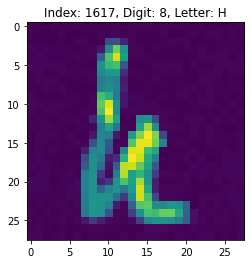

In [5]:
idx = np.random.randint(0, 2048)
img = DFtrain.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = DFtrain.loc[idx, 'digit']
letter = DFtrain.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

In [6]:
class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self):
        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):
        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        X_train = (DFtrain[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)
        y_train = to_categorical(DFtrain['digit'].values)

        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("%d.png" % epoch)
        plt.close()


cgan = CGAN()
cgan.train(epochs=20000, batch_size=32, sample_interval=200)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0

In [7]:
BuildModel = CGAN().build_discriminator().save('PredModel.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)              

In [8]:
new_model = tf.keras.models.load_model('PredModel.h5')
new_model(img.reshape(28, 28, 1))

AssertionError: Could not compute output Tensor("sequential_4/dense_19/Sigmoid_1:0", shape=(None, 1), dtype=float32)

In [9]:
anim_file = 'cGAN.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

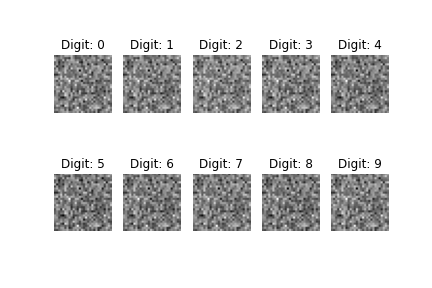

In [10]:
display.Image(filename=f'cGAN.gif')